In [8]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np 
import pandas as pd
import seaborn as sns
from src.preprocess import stratify5
from src.aggregate_features import generate_lrtt_features, generate_maf_features
from src.read_data import load_reference_data2
from src.smoothing import apply_smoothing, expand_coefficients

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score


In [9]:
#LOAD DATASETS
phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')
maf = pd.read_csv('./data/derived/imputed_MAF_data2.csv')
ambig = pd.read_csv('./data/derived/ambiguity/ambiguity_genes.csv')

#ADD TSI CATEGORIES
phylo = stratify5(phylo)
maf = stratify5(maf)

#sort by ID and coordinate
phylo = phylo.sort_values(by=['RENAME_ID', 'xcoord'])
maf = maf.sort_values(by=['RENAME_ID', 'Window_Centre'])

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96310/1668579925.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  phylo = pd.read_csv('./data/derived/imputed_phylo_data.csv')


# 1 - PREPARE DATA

In [10]:
#ENCODE STRATA IN FIVE CLASSES
tsi_order = ['0m-6m', '6m-12m', '12m-24m', '2y-4y', '4y+']
ordinal_encoder = OrdinalEncoder(categories=[tsi_order])
phylo['TSI_encoded'] = ordinal_encoder.fit_transform(phylo[['TSI_category']])
maf['TSI_encoded'] = ordinal_encoder.fit_transform(maf[['TSI_category']])

#FIND UNIQUE IDS   
unique_ids = phylo['RENAME_ID'].unique()
#SPLIT BASED ON IDS
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42)

#TRAIN AND TEST DATASETS
train_phylo = phylo[phylo['RENAME_ID'].isin(train_ids)]
test_phylo = phylo[phylo['RENAME_ID'].isin(test_ids)]
train_maf = maf[maf['RENAME_ID'].isin(train_ids)]
test_maf = maf[maf['RENAME_ID'].isin(test_ids)]
train_ambig = ambig[ambig['RENAME_ID'].isin(train_ids)]
test_ambig = ambig[ambig['RENAME_ID'].isin(test_ids)]

# 2 - BSPLINE SMOOTHING

## knots

In [11]:
# B-SPLINE SMOOTHING LRTT, MAF12C, AND MAF3C
smoothed_lrtt_train, coefficients_lrtt_train = apply_smoothing(train_phylo, 'xcoord', 'normalised.largest.rtt', 14)
smoothed_maf12c_train, coefficients_maf12c_train = apply_smoothing(train_maf, 'Window_Centre', 'MAF12c_Mean', 16)
smoothed_maf3c_train, coefficients_maf3c_train = apply_smoothing(train_maf, 'Window_Centre', 'MAF3c_Mean', 6)

smoothed_lrtt_test, coefficients_lrtt_test = apply_smoothing(test_phylo, 'xcoord', 'normalised.largest.rtt', 14)
smoothed_maf12c_test, coefficients_maf12c_test = apply_smoothing(test_maf, 'Window_Centre', 'MAF12c_Mean', 16)
smoothed_maf3c_test, coefficients_maf3c_test = apply_smoothing(test_maf, 'Window_Centre', 'MAF3c_Mean', 6)

#adding smoothed values
train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
train_maf['smoothed_maf12c'] = smoothed_maf12c_train
train_maf['smoothed_maf3c'] = smoothed_maf3c_train

test_phylo['smoothed_lrtt'] = smoothed_lrtt_test
test_maf['smoothed_maf12c'] = smoothed_maf12c_test
test_maf['smoothed_maf3c'] = smoothed_maf3c_test

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96310/1360101914.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_phylo['smoothed_lrtt'] = smoothed_lrtt_train
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96310/1360101914.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_maf['smoothed_maf12c'] = smoothed_maf12c_train
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96310/1360101914.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

## Plot - Mean Smoothed vs. Original

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96310/543108891.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_96310/543108891.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({


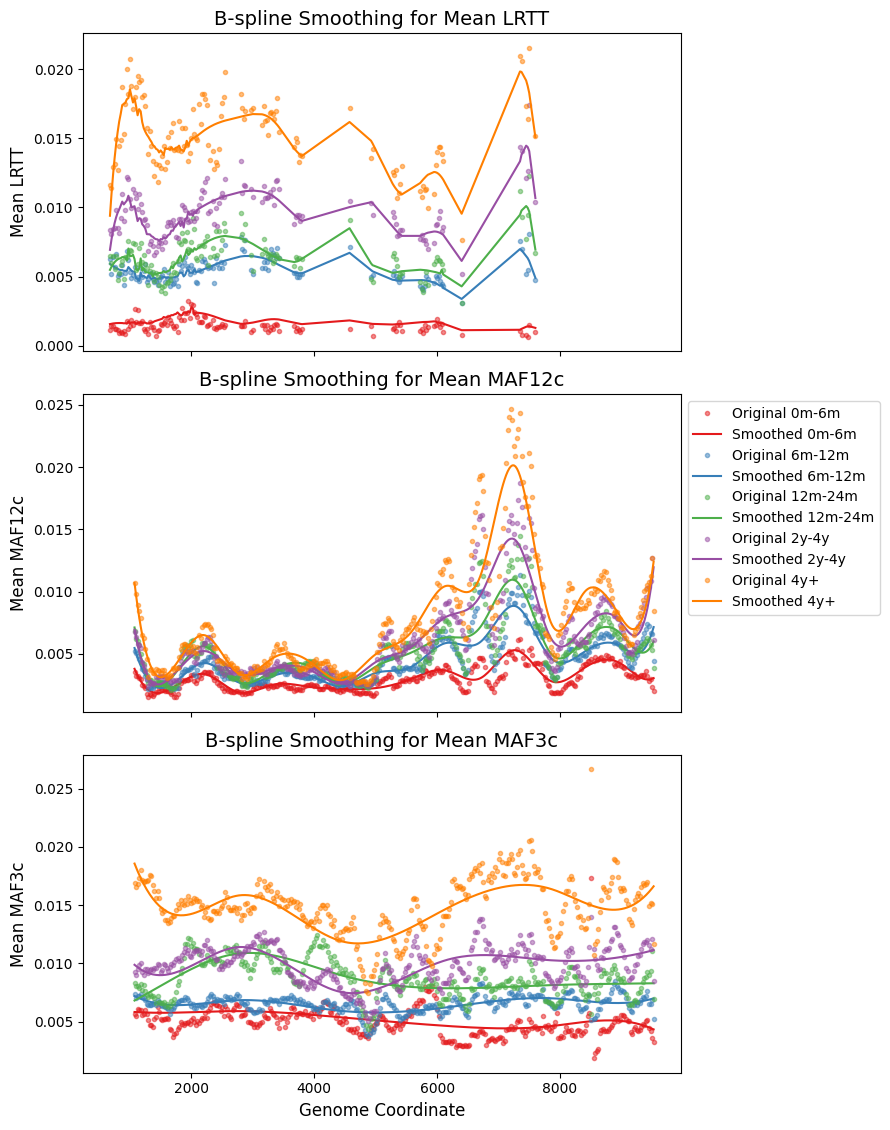

In [12]:
#Aggregate original and smoothed LRTT by TSI class and genome coordinate
mean_values = train_phylo.groupby(['TSI_category', 'xcoord']).agg({
    'normalised.largest.rtt': 'mean',
    'smoothed_lrtt': 'mean'
}).reset_index()

#Aggregate MAF12c, MAF3c by TSI class and genome coordinate
mean_values_maf = train_maf.groupby(['TSI_category', 'Window_Centre']).agg({
    'MAF12c_Mean': 'mean',
    'smoothed_maf12c': 'mean',
    'MAF3c_Mean': 'mean',
    'smoothed_maf3c': 'mean'
}).reset_index()


fig, axs = plt.subplots(3, 1, figsize=(9, 12), sharex=True)
palette = sns.color_palette("Set1", n_colors=5)

# Plot for LRTT
for i, category in enumerate(mean_values['TSI_category'].unique()):
    category_df = mean_values[mean_values['TSI_category'] == category]
    axs[0].plot(category_df['xcoord'], category_df['normalised.largest.rtt'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[0].plot(category_df['xcoord'], category_df['smoothed_lrtt'], '-', label=f'Smoothed {category}', color=palette[i], linewidth=1.5)

axs[0].set_ylabel('Mean LRTT', size = 12)
axs[0].set_title('B-spline Smoothing for Mean LRTT', size = 14)

# Plot for MAF12c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[1].plot(category_df['Window_Centre'], category_df['MAF12c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[1].plot(category_df['Window_Centre'], category_df['smoothed_maf12c'], '-', label=f'Smoothed {category}', color=palette[i], linewidth=1.5)

axs[1].set_ylabel('Mean MAF12c',  size = 12)
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
axs[1].set_title('B-spline Smoothing for Mean MAF12c', size = 14)

# Plot for MAF3c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    category_df = mean_values_maf[mean_values_maf['TSI_category'] == category]
    axs[2].plot(category_df['Window_Centre'], category_df['MAF3c_Mean'], 'o', markersize=3, label=f'Original {category}', color=palette[i], alpha=0.5)
    axs[2].plot(category_df['Window_Centre'], category_df['smoothed_maf3c'], '-', label=f'Smoothed {category}', color=palette[i], linewidth=1.5)

axs[2].set_xlabel('Genome Coordinate', size = 12)
axs[2].set_ylabel('Mean MAF3c', size = 12)
axs[2].set_title('B-spline Smoothing for Mean MAF3c', size = 14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./outputs/smoothing/average_bspline.pdf')
plt.show()

# Plot - Individual Samples vs. Smoothing

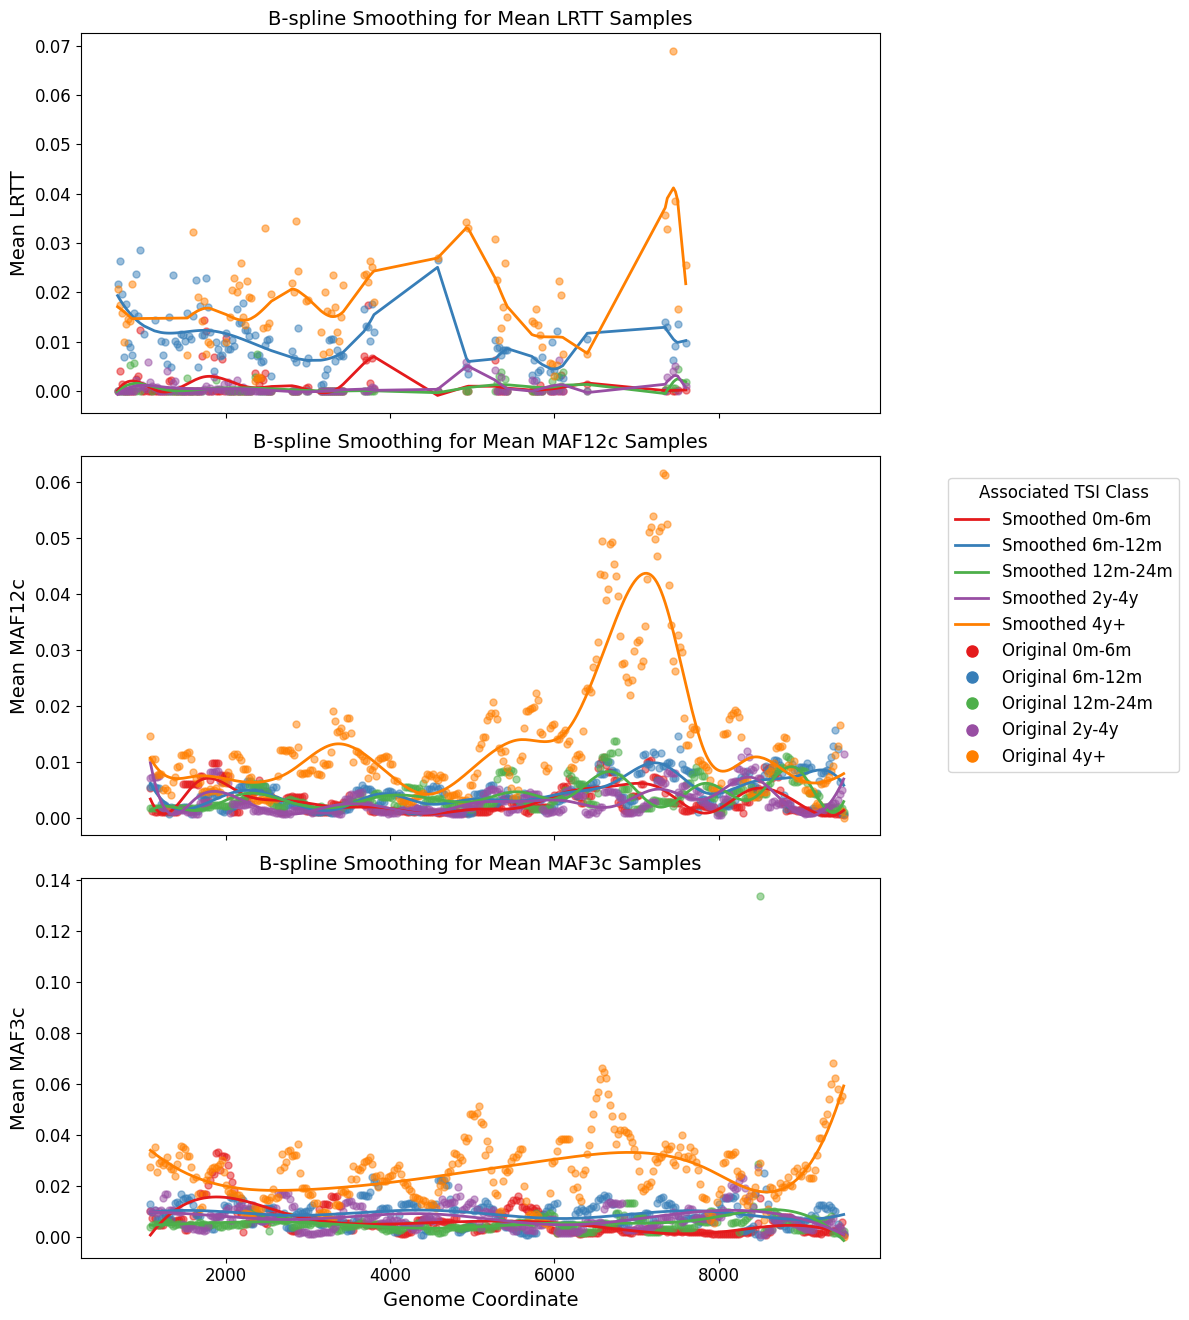

In [30]:
np.random.seed(12) #set random seed
fig, axs = plt.subplots(3, 1, figsize=(9, 14), sharex=True) 
palette = sns.color_palette("Set1", n_colors=5)

# Number of samples to draw per class (number of unique RENAME_IDs)
num_samples_per_class = 1
sampled_ids_by_class = {}

# Plot for LRTT
for i, category in enumerate(mean_values['TSI_category'].unique()):
    unique_ids = train_phylo[train_phylo['TSI_category'] == category]['RENAME_ID'].unique() #get unique sample ids
    sampled_ids = np.random.choice(unique_ids, num_samples_per_class, replace=False) #randomly pick samples
    sampled_ids_by_class[category] = sampled_ids 

    # Plot each sampled RENAME_ID
    for rename_id in sampled_ids:
        sample_df = train_phylo[train_phylo['RENAME_ID'] == rename_id]
        #original data as scatter
        axs[0].scatter(sample_df['xcoord'], sample_df['normalised.largest.rtt'], s=25, marker='o', color=palette[i], alpha=0.5)
        #smoothed data as smooth curve
        axs[0].plot(sample_df['xcoord'], sample_df['smoothed_lrtt'], '-', color=palette[i], linewidth=2)

axs[0].set_ylabel('Mean LRTT', fontsize=14)
axs[0].set_title('B-spline Smoothing for Mean LRTT Samples', fontsize=14)
axs[0].tick_params(axis='y', which='major', labelsize=12)

# Plot for MAF12c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    sampled_ids = sampled_ids_by_class.get(category, []) #use consistent set of samples
    # Plot each sampled RENAME_ID
    for rename_id in sampled_ids:
        sample_df = train_maf[train_maf['RENAME_ID'] == rename_id]
        axs[1].scatter(sample_df['Window_Centre'], sample_df['MAF12c_Mean'], s=25, marker='o', color=palette[i], alpha=0.5)
        axs[1].plot(sample_df['Window_Centre'], sample_df['smoothed_maf12c'], '-', color=palette[i], linewidth=2)

axs[1].set_ylabel('Mean MAF12c', fontsize=14)
axs[1].set_title('B-spline Smoothing for Mean MAF12c Samples', fontsize=14)
axs[1].tick_params(axis='y', which='major', labelsize=12)

# Plot for MAF3c
for i, category in enumerate(mean_values_maf['TSI_category'].unique()):
    # Use the same sampled RENAME_IDs as stored earlier
    sampled_ids = sampled_ids_by_class.get(category, [])
    
    for rename_id in sampled_ids:
        sample_df = train_maf[train_maf['RENAME_ID'] == rename_id]
        axs[2].scatter(sample_df['Window_Centre'], sample_df['MAF3c_Mean'], s=25, marker='o', color=palette[i], alpha=0.5)
        axs[2].plot(sample_df['Window_Centre'], sample_df['smoothed_maf3c'], '-', color=palette[i], linewidth=2)

axs[2].set_xlabel('Genome Coordinate', fontsize=14)
axs[2].set_ylabel('Mean MAF3c', fontsize=14)
axs[2].set_title('B-spline Smoothing for Mean MAF3c Samples', fontsize=14)
axs[2].tick_params(axis='both', which='major', labelsize=12)

legend_lines = [mlines.Line2D([], [], color=palette[i], linestyle='-', linewidth=2, label=f'Smoothed {category}') for i, category in enumerate(mean_values['TSI_category'].unique())]
legend_markers = [mlines.Line2D([], [], color=palette[i], marker='o', linestyle='None', markersize=8, label=f'Original {category}') for i, category in enumerate(mean_values['TSI_category'].unique())]

handles = legend_lines + legend_markers
fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fontsize=12, frameon=True, title = 'Associated TSI Class', title_fontsize = 12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./outputs/smoothing/sampled_bspline_by_class.pdf', bbox_inches='tight')
plt.show()

In [18]:
#save individuals sampled
import pickle
with open('./outputs/smoothing/sampled_ids_by_class.pkl', 'wb') as f:
    pickle.dump(sampled_ids_by_class, f)

## Feature Aggregation

In [23]:
first_second_codon_pos, third_codon_pos, gag, pol, gp120, gp41 = load_reference_data2('./data/')

# Generate aggregated features for train and test datasets separately
train_phylo_features = generate_lrtt_features(train_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
test_phylo_features = generate_lrtt_features(test_phylo, gag, pol, gp120, gp41, feature='smoothed_lrtt')
train_maf_features = generate_maf_features(train_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')
test_maf_features = generate_maf_features(test_maf, gag, pol, gp120, gp41, feature_12c = 'smoothed_maf12c', feature_3c= 'smoothed_maf3c')

# Merge the aggregated features
train_features = pd.merge(train_phylo_features, train_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')
test_features = pd.merge(test_phylo_features, test_maf_features, on=['RENAME_ID', 'TSI_days'], how = 'inner')

In [24]:
# Finalize the features by stratifying classes
train_features = stratify5(train_features)
test_features = stratify5(test_features)

### adding $\xi$ to feature set

In [25]:
# Add spline coefficients to the aggregated features
train_features = expand_coefficients(train_features, coefficients_lrtt_train, 'lrtt')
train_features = expand_coefficients(train_features, coefficients_maf12c_train, 'maf12c')
train_features = expand_coefficients(train_features, coefficients_maf3c_train, 'maf3c')

test_features = expand_coefficients(test_features, coefficients_lrtt_test, 'lrtt')
test_features = expand_coefficients(test_features, coefficients_maf12c_test, 'maf12c')
test_features = expand_coefficients(test_features, coefficients_maf3c_test, 'maf3c')


## ADD AMBIGUITY

In [37]:
# Merge ambiguity data
train_features = pd.merge(train_features, train_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')
test_features = pd.merge(test_features, test_ambig[['RENAME_ID', 'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']], on='RENAME_ID', how='inner')

train_features.to_csv('./data/derived/feature_selection/training_data_with_dual.csv', header = True)
test_features.to_csv('./data/derived/feature_selection/test_data_with_dual.csv', header = True)